In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from random import randint
import skimage.transform
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Concatenate, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import tensorflow.keras.backend as K
import math
import ast
import time
print(tf.__version__)

2.3.0


In [ ]:
TRAIN_FEATURES_PATH = r'/content/gdrive/MyDrive/Univ/ML project 2/data/train/images//'
TRAIN_LABELS_PATH = r'/content/gdrive/MyDrive/Univ/ML project 2/data/train/groundtruth//'
TRAIN_SAMPLES = 100
VALIDATION_RATIO = 0.1
USE_SHUFFLE = True
INPUT_HEIGHT = 128
INPUT_WIDTH = 128
CUTTING_SHIFT = 16

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def load_data():
    x_train = []
    y_train = []
    for i in range(TRAIN_SAMPLES):
        img_name = 'satImage_{:03}.png'.format(i+1)
        train_feature = plt.imread(TRAIN_FEATURES_PATH + img_name)
        train_label = plt.imread(TRAIN_LABELS_PATH + img_name)
        x_train.append(train_feature)
        y_train.append(train_label)
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    return x_train, y_train

def transform_labels(y_train):
    y_train = np.round(y_train)
    y_train = y_train[..., np.newaxis]
    return y_train

def permute(x, y):
    indexes = np.random.permutation(np.arange(x.shape[0]))
    x = x[indexes]
    y = y[indexes]
    return x, y

def train_test_split(x, y, validation_ratio = 0.1, shuffle=True):
    train_num = int(np.round(x.shape[0] * (1 - validation_ratio)))
    if shuffle:
        x, y = permute(x, y)
    x_test = x[train_num:,:,:,:]
    y_test = y[train_num:,...]
    x_train = x[:train_num,...]
    y_train = y[:train_num,...]
    return x_train, y_train, x_test, y_test

def cut_data(img, h=INPUT_HEIGHT, w=INPUT_WIDTH, shift=CUTTING_SHIFT):
    img_cutted = [img[k,x:x+h,y:y+w,:] for x in range(0,img.shape[1]-h+1,shift) for y in range(0,img.shape[2]-w+1,shift) for k in range(img.shape[0])]
    return np.array(img_cutted)

(29160, 128, 128, 3)
(29160, 128, 128, 1)
(3240, 128, 128, 3)
(3240, 128, 128, 1)


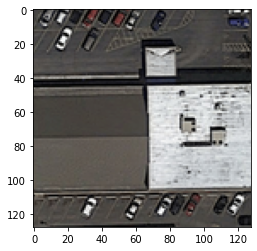

In [ ]:
#load and transform
x_train, y_train = load_data()
y_train = transform_labels(y_train)

#train test split
x_train, y_train, x_test, y_test = train_test_split(x_train, y_train, VALIDATION_RATIO, USE_SHUFFLE)

#cut
x_train_cutted = cut_data(x_train)
y_train_cutted = cut_data(y_train)
x_test_cutted = cut_data(x_test)
y_test_cutted = cut_data(y_test)

#check
print(x_train_cutted.shape)
print(y_train_cutted.shape)
print(x_test_cutted.shape)
print(y_test_cutted.shape)
plt.imshow(x_train_cutted[0])
plt.show()

In [ ]:
def get_model(dropout_rate = 0.2):
    inputs = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
    conv1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='elu')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    conv1 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='elu')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D((2, 2), strides=(2,2))(conv1)
    
    conv2 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation='elu')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    conv2 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation='elu')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D((2, 2), strides=(2,2))(conv2)
    
    conv3 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='elu')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    conv3 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='elu')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D((2, 2), strides=(2,2))(conv3)
    
    conv4 = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='elu')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    conv4 = Conv2D(128, (3,3), strides=(1,1), padding='same', activation='elu')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    upsample5 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='linear')(conv4)
    upsample5 = Concatenate(axis=-1)([upsample5, conv3])
    conv5 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='elu')(upsample5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(dropout_rate)(conv5)
    conv5 = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='elu')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    upsample6 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', activation='linear')(conv5)
    upsample6 = Concatenate(axis=-1)([upsample6, conv2])
    conv6 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation='elu')(upsample6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(dropout_rate)(conv6)
    conv6 = Conv2D(32, (3,3), strides=(1,1), padding='same', activation='elu')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    upsample7 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same', activation='linear')(conv6)
    upsample7 = Concatenate(axis=-1)([upsample7, conv1])
    conv7 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='elu')(upsample7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(dropout_rate)(conv7)
    conv7 = Conv2D(16, (3,3), strides=(1,1), padding='same', activation='elu')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    outputs = Conv2D(1, (3,3), strides=(1,1), padding='same', activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer = 'adam', loss = soft_dice_loss, metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)  
    return iou

def intersec_over_union_loss(y_true, y_pred, delta = 10e-5):
    return - np.sum(np.minimum(y_true, y_pred)) / (np.sum(np.maximum(y_true, y_pred))+delta)

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model = get_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model.fit(x_train_cutted, y_train_cutted, validation_data=(x_test_cutted, y_test_cutted), epochs=5, batch_size=16)

Epoch 1/5
1823/1823 [==============================] - 89s 49ms/step - loss: 0.0944 - precision: 0.9137 - recall: 0.9010 - val_loss: 0.1454 - val_precision: 0.8596 - val_recall: 0.8525
Epoch 2/5
1823/1823 [==============================] - 89s 49ms/step - loss: 0.0644 - precision: 0.9415 - recall: 0.9324 - val_loss: 0.1395 - val_precision: 0.8841 - val_recall: 0.8391
Epoch 3/5
1823/1823 [==============================] - 88s 49ms/step - loss: 0.0489 - precision: 0.9556 - recall: 0.9485 - val_loss: 0.1794 - val_precision: 0.9155 - val_recall: 0.7445
Epoch 4/5
1823/1823 [==============================] - 88s 48ms/step - loss: 0.0398 - precision: 0.9640 - recall: 0.9581 - val_loss: 0.1319 - val_precision: 0.8830 - val_recall: 0.8557
Epoch 5/5
1823/1823 [==============================] - 88s 48ms/step - loss: 0.0356 - precision: 0.9677 - recall: 0.9625 - val_loss: 0.1578 - val_precision: 0.8871 - val_recall: 0.8032


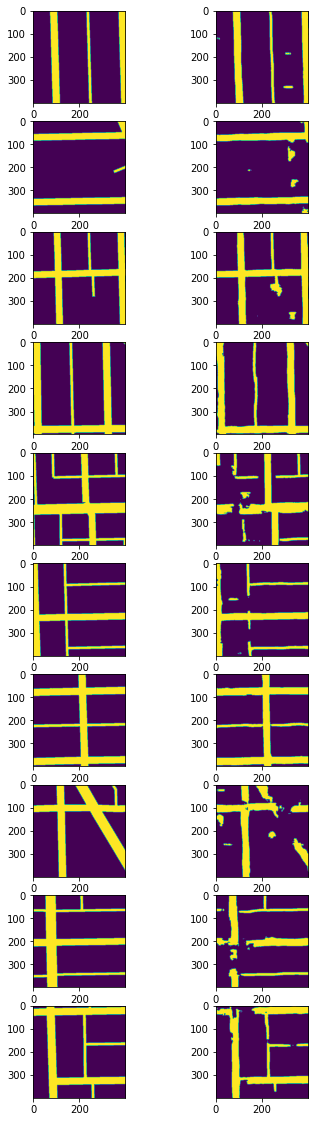

In [ ]:
fig, ax = plt.subplots(10,2, figsize=(6, 20))
for i in range(10):
    y_pred = model.predict(x_test[i:i+1])
    ax[i,0].imshow(y_test[i][:,:,0])
    ax[i,1].imshow(y_pred[0,:,:,0])
plt.show()